In [ ]:
# !pip install transformers # done


In [3]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli")
sequence_to_classify = "Angela Merkel is a politician in Germany and leader of the CDU"
candidate_labels = ["politics", "economy", "entertainment", "environment"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)

d:\anaconda_neel\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\NEELKANTH RAWAT\.cache\huggingface\hub\models--MoritzLaurer--DeBERTa-v3-large-mnli-fever-anli-ling-wanli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


{'sequence': 'Angela Merkel is a politician in Germany and leader of the CDU', 'labels': ['politics', 'environment', 'economy', 'entertainment'], 'scores': [0.9967535734176636, 0.0014776686439290643, 0.0012541556498035789, 0.0005145781906321645]}


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [7]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
### This code-cell took way too long to load for some reason
device = "cpu"

model_name = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


In [34]:
eg1_p, eg1_h = "Inflation in Venezuela", "High prices in Venezuela"#"He snored", "He slept"
eg2_p, eg2_h = "The sun will shine", "Rain Falls"

premise, hypothesis = eg1_p, eg1_h#eg1_p, eg1_h

input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
output = model(input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
prediction = torch.softmax(output["logits"][0], -1).tolist()
label_names = ["entailment", "neutral", "contradiction"]
prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
print(prediction)


{'entailment': 97.5, 'neutral': 2.5, 'contradiction': 0.1}


Let's change everything to functions

In [14]:
from tqdm import tqdm
def load_model():
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model_name = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
    return tokenizer, model, device

def classify_nli(tokenizer, model, device, premise, hypothesis):
    inputs = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.softmax(outputs.logits, dim=-1)[0]
    label_names = ["entailment", "neutral", "contradiction"]
    prediction_scores = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
    predicted_label = label_names[torch.argmax(prediction)]
    return predicted_label, prediction_scores

def process_file(input_file, output_file):
    tokenizer, model, device = load_model()
    with open(input_file, "r") as infile, open(output_file, "w") as outfile:
        lines = infile.readlines()
        for line in tqdm(lines, desc="Processing pairs"):
            premise, hypothesis = line.strip().split("\t")
            predicted_label, prediction_scores = classify_nli(tokenizer, model, device, premise, hypothesis)
            outfile.write(f"{premise}\t{hypothesis}\t{predicted_label}\t{prediction_scores}\n")


In [15]:
if __name__ == "__main__":
    input_file = "D:\\Desktop\\master_scientific_computing\\second_semester\\problems with data\\Problems-With-Data--Summer-2024\\exercise-2\\task2-3\\toannotate.txt"
    output_file = "nli_results.txt"
    process_file(input_file, output_file)


Processing pairs: 100%|██████████| 30/30 [01:13<00:00,  2.46s/it]


### Binary predictions:

In [36]:
def generate_binary_predictions(input_file, output_file):
    with open(input_file, "r") as infile, open(output_file, "w") as outfile:
        for line in infile:
            premise, hypothesis, predicted_label, prediction_scores_str = line.strip().split("\t")
            prediction_scores = eval(prediction_scores_str)
            entailment_score = prediction_scores['entailment']
            neutral_score = prediction_scores['neutral']
            if entailment_score > neutral_score:
                binary_label = "E"
            else:
                binary_label = "NE"
            outfile.write(f"{premise}\t{hypothesis}\t{binary_label}\n")

# Example usage:
input_file = "nli_results.txt"
output_file = "nli_binary_predictions.txt"
generate_binary_predictions(input_file, output_file)


### Let's compare it aganist our own predictions.

In [27]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import json

import matplotlib.pyplot as plt
import seaborn as sns


In [44]:
def load_annotations(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            premise, hypothesis, annotation = line.strip().split("\t")
            data.append((premise, hypothesis, annotation))
    return pd.DataFrame(data, columns=["Premise", "Hypothesis", "Annotation"])

def load_nli_results(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split("\t")
            premise, hypothesis, predicted_label = parts[0], parts[1], parts[2]
            # Try to parse the prediction_scores, ensure it's a proper JSON format
            try:
                prediction_scores = json.loads(parts[3].replace("'", "\""))  # Ensure double quotes for JSON
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON for line: {line}")
                continue
            data.append((premise, hypothesis, predicted_label, prediction_scores))
    return pd.DataFrame(data, columns=["Premise", "Hypothesis", "Predicted_Label", "Prediction_Scores"])


def load_nli_binary_predictions(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            premise, hypothesis, binary_label = line.strip().split("\t")
            data.append((premise, hypothesis, binary_label))
    return pd.DataFrame(data, columns=["Premise", "Hypothesis", "Predicted_Label_2_Class"])


def convert_to_2_class(label):
    return "E" if label == "entailment" else "NE"

def evaluate_annotations_vs_nli(annotations_df, nli_df):
    # Merge annotations and NLI results on premise and hypothesis
    merged_df = pd.merge(annotations_df, nli_df, on=["Premise", "Hypothesis"])
    merged_df["Predicted_Label_2_Class"] = merged_df["Predicted_Label"].apply(convert_to_2_class)
    
    # Compute confusion matrix and evaluation metrics
    y_true = merged_df["Annotation"]
    y_pred = merged_df["Predicted_Label_2_Class"]
    
    cm = confusion_matrix(y_true, y_pred, labels=["E", "NE"])
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=["E", "NE"], average=None)
    
    return cm, precision, recall, f1

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



Confusion Matrix:
[[13  4]
 [10  3]]

Precision, Recall, F1-Score for 'E' and 'NE':
E - Precision: 0.57, Recall: 0.76, F1-Score: 0.65
NE - Precision: 0.43, Recall: 0.23, F1-Score: 0.30


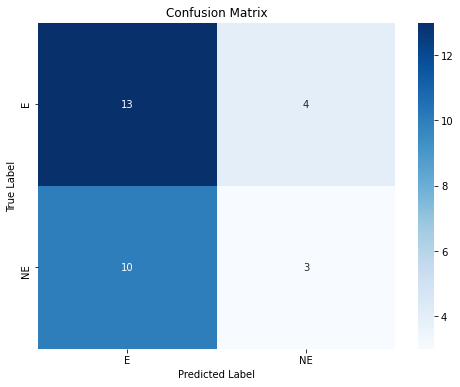

In [45]:
def main():
    annotations_file = "D:\\Desktop\\master_scientific_computing\\second_semester\\problems with data\\Problems-With-Data--Summer-2024\\exercise-2\\task2-3\\toannotate_Neelkanth_Rawat.txt"
    nli_results_file = "nli_results.txt"
    
    annotations_df = load_annotations(annotations_file)
    nli_df =  load_nli_results(nli_results_file)
    
    cm, precision, recall, f1 = evaluate_annotations_vs_nli(annotations_df, nli_df)
    
    print("Confusion Matrix:")
    print(cm)
    
    print("\nPrecision, Recall, F1-Score for 'E' and 'NE':")
    for label, p, r, f in zip(["E", "NE"], precision, recall, f1):
        print(f"{label} - Precision: {p:.2f}, Recall: {r:.2f}, F1-Score: {f:.2f}")

    plot_confusion_matrix(cm, labels=["E", "NE"])

if __name__ == "__main__":
    main()

with binary predictions:

Confusion Matrix:
[[13  4]
 [10  3]]
Precision: [0.56521739 0.42857143]
Recall: [0.76470588 0.23076923]
F1 Score: [0.65 0.3 ]


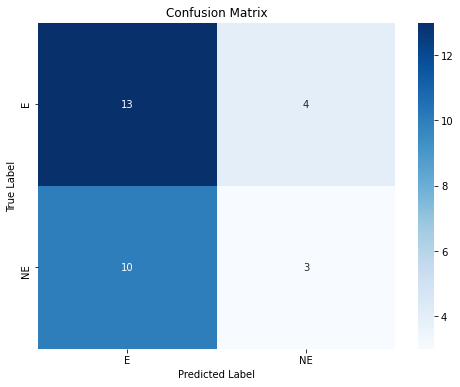

In [47]:
def load_binary_predictions(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            premise, hypothesis, binary_label = line.strip().split("\t")
            data.append((premise, hypothesis, binary_label))
    return pd.DataFrame(data, columns=["Premise", "Hypothesis", "Predicted_Label_2_Class"])

def evaluate_annotations_vs_nli(annotations_df, nli_df):
    # Merge annotations and NLI results on premise and hypothesis
    merged_df = pd.merge(annotations_df, nli_df, on=["Premise", "Hypothesis"])
    
    # Compute confusion matrix and evaluation metrics
    y_true = merged_df["Annotation"]
    y_pred = merged_df["Predicted_Label_2_Class"]
    
    cm = confusion_matrix(y_true, y_pred, labels=["E", "NE"])
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=["E", "NE"], average=None)
    
    return cm, precision, recall, f1

def main():
    annotations_file = "D:\\Desktop\\master_scientific_computing\\second_semester\\problems with data\\Problems-With-Data--Summer-2024\\exercise-2\\task2-3\\toannotate_Neelkanth_Rawat.txt"
    nli_binary_predictions_file = "nli_binary_predictions.txt"

    annotations_df = load_annotations(annotations_file)
    nli_df = load_binary_predictions(nli_binary_predictions_file)

    cm, precision, recall, f1 = evaluate_annotations_vs_nli(annotations_df, nli_df)
    print("Confusion Matrix:")
    print(cm)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    
    plot_confusion_matrix(cm, labels=["E", "NE"])

if __name__ == "__main__":
    main()
